In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd
from functools import partial

from prepare_plasticc import config
from tokenizer import LCTokenizer
from viz import plot_lightcurve
from gaussian_process import fit_2d_gp
import time

from models.patchgpt import PatchGPT
import torch

/opt/anaconda3/envs/gpt-ts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('plasticc/plasticc_train_lightcurves.csv.gz')
#df = pd.read_csv('plasticc/plasticc_test_lightcurves_02.csv.gz')

In [3]:
object_ids = np.unique(df['object_id'].values)

In [4]:
tokenizer = LCTokenizer(config["min_flux"], config["max_flux"], config["num_bins"], config["max_delta_time"],
                            config["num_time_bins"], bands=config["bands"],
                            transform=np.arcsinh, inverse_transform=np.sinh,
                            min_sn=3, window_size=5)

In [5]:
start_time = time.time()
#tokenizer.encode(df)
print(time.time() - start_time)

2.5987625122070312e-05


0.2092268466949463


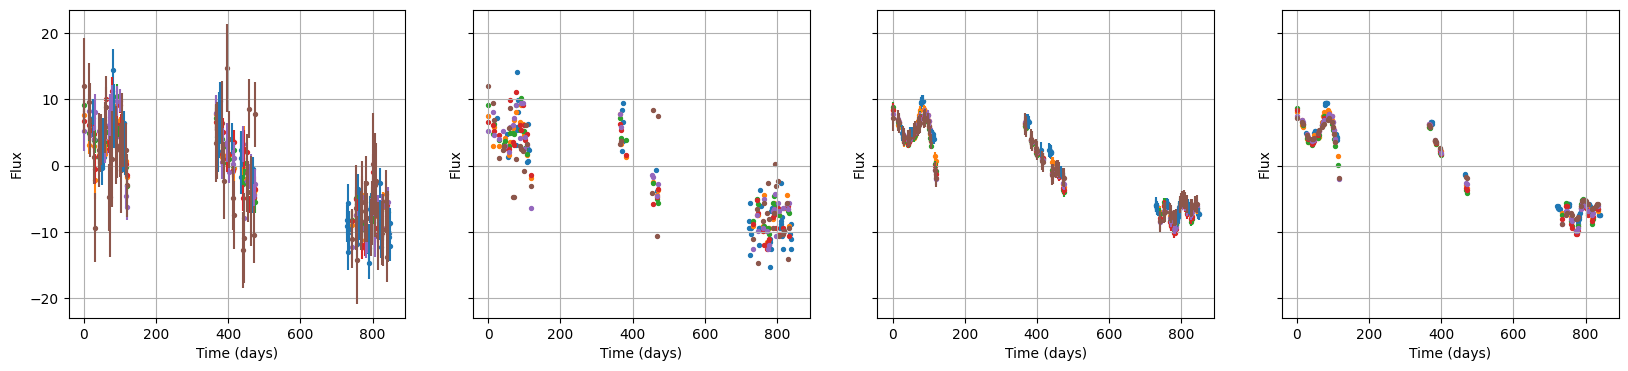

In [6]:
for object_id in object_ids[1:2]:
    df_object = df.loc[df['object_id'] == object_id]
    df_object.loc[:, 'mjd'] = df_object.loc[:, 'mjd'] - min(df_object['mjd']) 
    start_time = time.time()
    resampled_df, (sampled_times, sampled_obs, _, sampled_mask) = fit_2d_gp(df_object, config['pb_wavelengths'], sample_interval=1)
    print(time.time() - start_time)
    plot_lightcurve([df_object, tokenizer.decode(tokenizer.encode(df_object)), resampled_df, tokenizer.decode(tokenizer.encode(resampled_df))])

In [7]:
sampled_obs.shape

(6, 849)

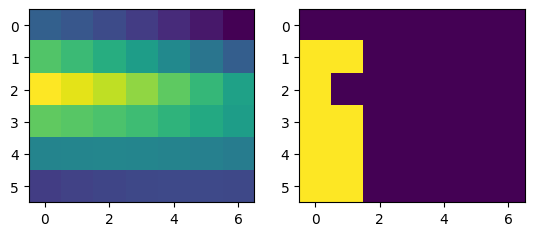

In [8]:
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(sampled_obs[:,0:7])
    axes[1].imshow(sampled_mask[:,0:7])
    plt.show()

In [9]:
patchify = PatchGPT(patch_size=7, n_embd=18, channels=6, n_layer=2, n_positions=1024, n_head=3)

In [10]:
patchify

PatchGPT(
  (to_patches): Rearrange('b c (n p) -> b n (p c)', p=7)
  (to_patch_embedding): Sequential(
    (0): LayerNorm((42,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=42, out_features=18, bias=True)
    (2): LayerNorm((18,), eps=1e-05, elementwise_affine=True)
  )
  (position_embedding_table): Embedding(1024, 18)
  (blocks): ModuleList(
    (0-1): 2 x Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-2): 3 x Head(
            (key): Linear(in_features=18, out_features=6, bias=False)
            (query): Linear(in_features=18, out_features=6, bias=False)
            (value): Linear(in_features=18, out_features=6, bias=False)
            (dropout): Dropout(p=0, inplace=False)
            (distance_embedding): Embedding(2047, 6)
          )
        )
        (proj): Linear(in_features=18, out_features=18, bias=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          

In [11]:
x = torch.tensor(np.expand_dims(sampled_obs, 0), dtype=torch.float32)
sampled_mask = torch.tensor(np.expand_dims(sampled_mask, 0), dtype=torch.int32)

In [12]:
output = patchify(x, mask=sampled_mask)

In [15]:
output.loss.size()

torch.Size([1, 122, 42])

In [16]:
plt.plot(output.logits[0,1,:].detach().numpy())

TypeError: 'NoneType' object is not subscriptable

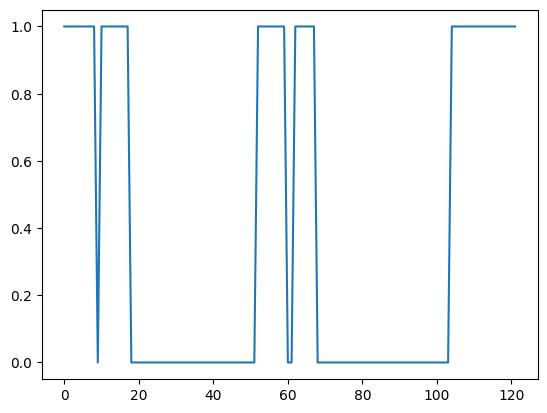

In [17]:
plt.plot(output.patch_mask[0,:].detach().numpy())